# Credit Rating Classification Model

This notebook demonstrates a comprehensive approach to building and evaluating a machine learning model for classifying credit ratings. The steps include data preprocessing, handling class imbalance using RandomOverSampler, model training with hyperparameter tuning, and model evaluation using various metrics.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

## Step 1: Load the Dataset

We start by loading the dataset and examining its structure.


In [2]:
# Load the dataset
data_path = 'MLF_GP1_CreditScore.csv'
data = pd.read_csv(data_path)

## Section - EDA

1. `Distribution plot` to analyse the number of instances in each each label that has to be classified.

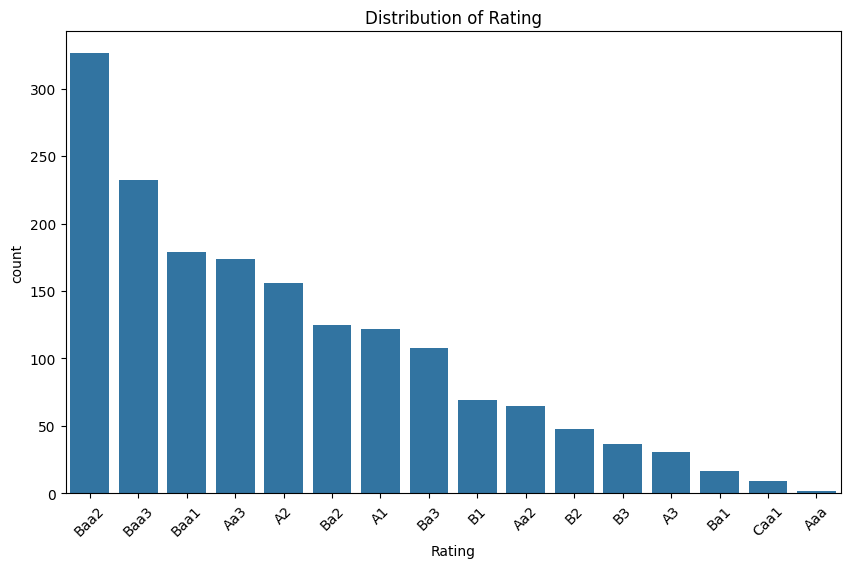

In [3]:
# 1. Distribution of the Target Variable (Rating)
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Rating', order=data['Rating'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Rating')
plt.show()

2. `Correlation plot` to identify redundant features that are correlated with each other.

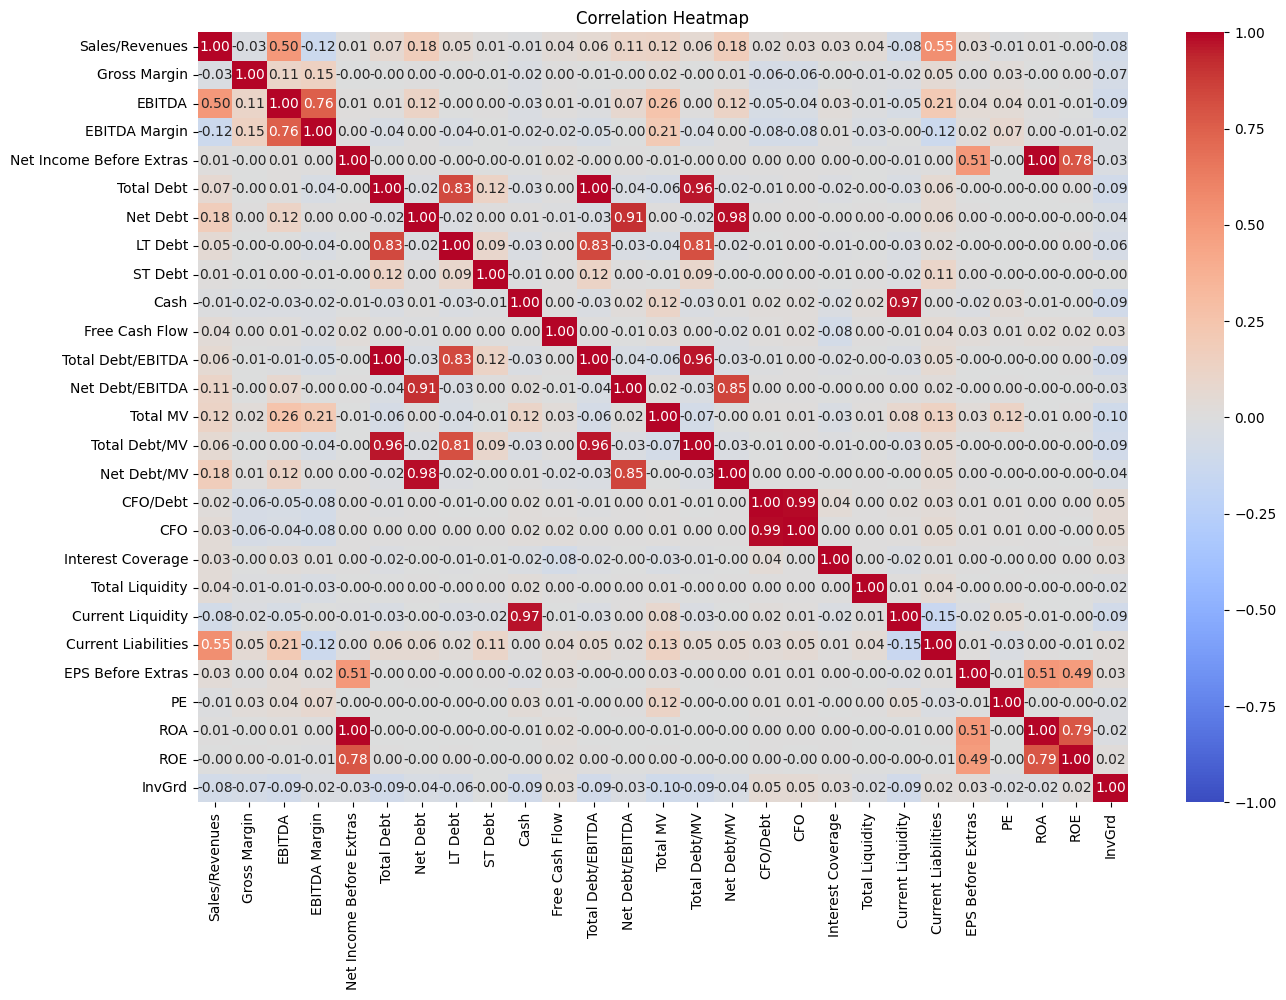

In [4]:
# 2. Correlation Heatmap
plt.figure(figsize=(15, 10))
correlation_matrix = data.iloc[:, :-1].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

3. `Box plot` to understand the skewness, distribution and outliers of the features set.

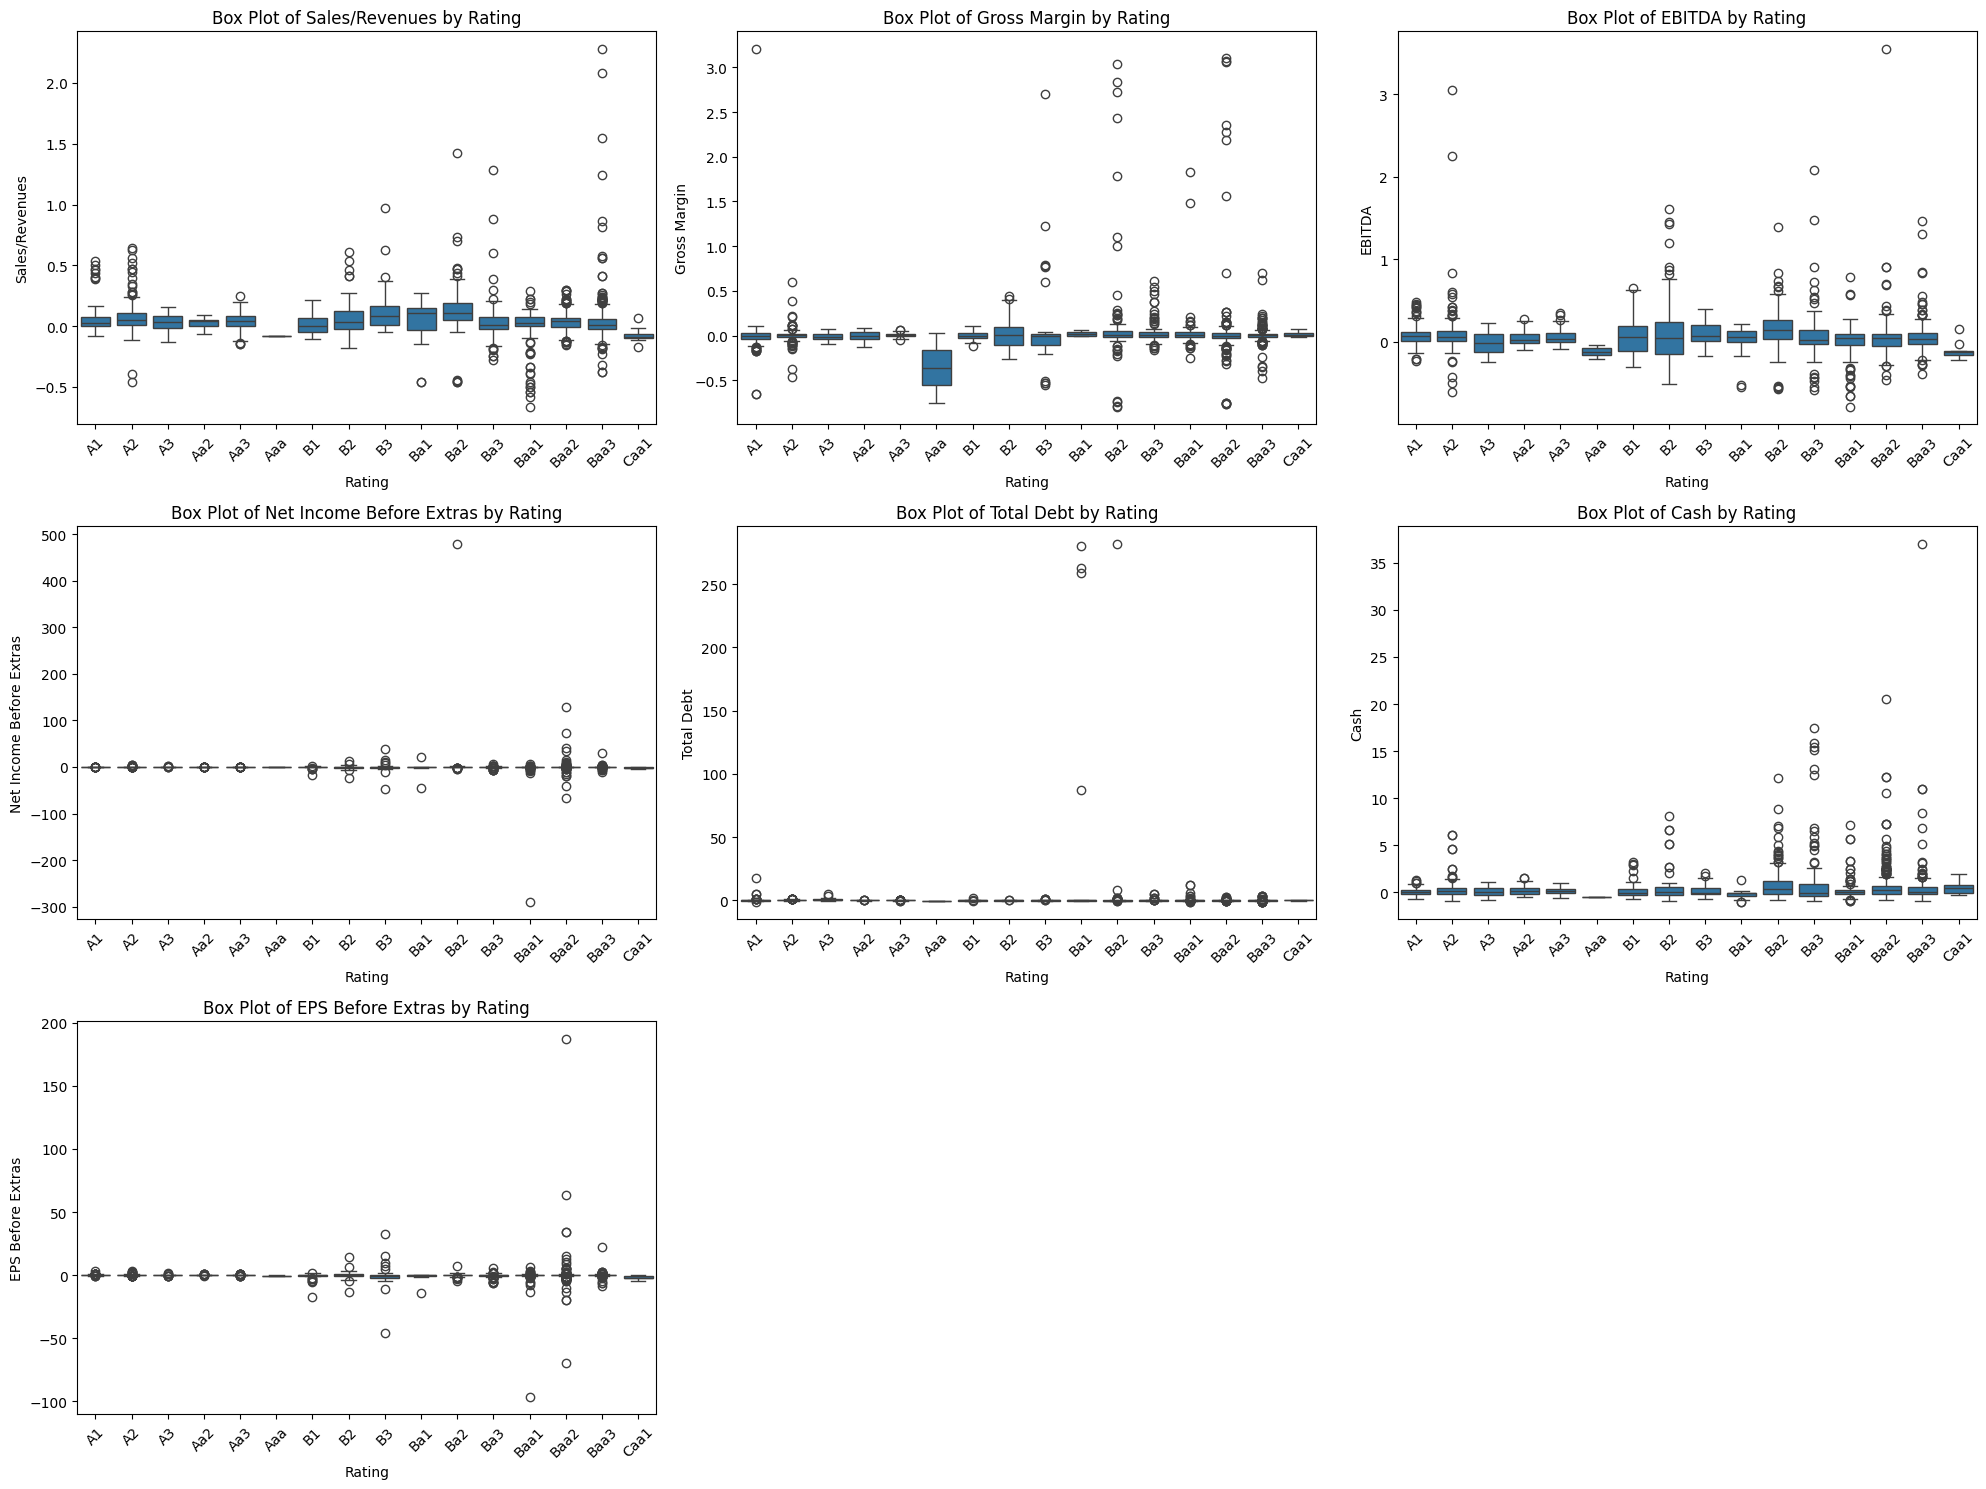

In [5]:
# 3. Box Plots for Key Financial Metrics
key_features = ['Sales/Revenues', 'Gross Margin', 'EBITDA', 'Net Income Before Extras', 'Total Debt', 'Cash', 'EPS Before Extras']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=data, x='Rating', y=feature)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot of {feature} by Rating')
plt.tight_layout()
plt.show()

## Step 2: Define Target and Features

We define the target variable (`Rating`) and the feature set by excluding the `Rating` and `InvGrd` columns.


In [7]:
# Define target and features
target = 'Rating'
features = data.columns.drop(['Rating', 'InvGrd'])

In [8]:
# Split the data into features and target
X = data[features]
y = data[target]

## Step 4: Data Preprocessing

### Numerical Data
- Impute missing values using the mean strategy.
- Scale the features using StandardScaler.

### Categorical Data
- Impute missing values using the most frequent value.
- Encode categorical features using OneHotEncoder.


In [9]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [10]:

# Preprocessing for numerical data: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [11]:

# Preprocessing for categorical data: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Create the Pipeline

We create a machine learning pipeline that includes the preprocessing steps and `Logistic Regression`. We use `RandomOverSampler` to handle class imbalance by oversampling the minority class and cleaning the data.


In [14]:
# Define the model
logistic_model = LogisticRegression(max_iter=1000)
random_forest_model = RandomForestClassifier(random_state=42)

In [15]:
# Create the pipeline with RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [16]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('ros', ros),
    ('classifier', logistic_model)
])


## Step 6: Hyperparameter Tuning for Logistic Regression

In [31]:
# Hyperparameter tuning for Logistic Regression
param_grid_logistic = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_logistic = GridSearchCV(pipeline, param_grid_logistic, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search_logistic.fit(X_train, y_train)
best_logistic_model = grid_search_logistic.best_estimator_

## Model execution and Evaluation

In [32]:
# Evaluate Logistic Regression model
y_pred_logistic = best_logistic_model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

          A1       0.13      0.08      0.10        24
          A2       0.29      0.06      0.10        33
          A3       0.09      0.60      0.16         5
         Aa2       0.17      0.60      0.26        15
         Aa3       0.31      0.43      0.36        42
         Aaa       0.00      0.00      0.00         0
          B1       0.07      0.05      0.06        19
          B2       0.00      0.00      0.00         5
          B3       0.14      0.29      0.19         7
         Ba1       0.20      0.33      0.25         6
         Ba2       0.24      0.35      0.29        23
         Ba3       0.11      0.04      0.06        23
        Baa1       0.08      0.03      0.05        31
        Baa2       0.46      0.10      0.16        63
        Baa3       0.28      0.21      0.24        43
        Caa1       0.00      0.00      0.00         1

    accuracy                           0.19       340
   macro avg       0.16   

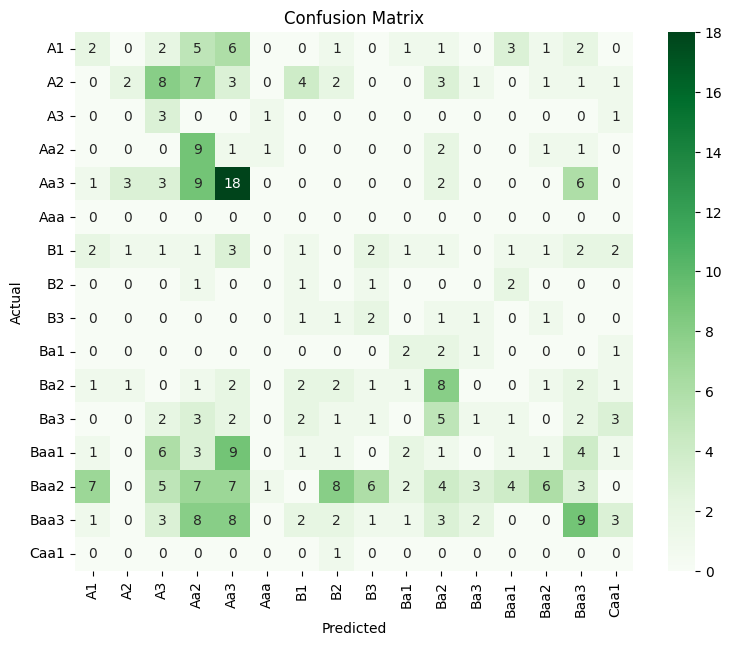

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logistic)
class_labels = best_logistic_model.named_steps['classifier'].classes_

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Step 7: Create the Pipeline

We create a machine learning pipeline that includes the preprocessing steps and `Random Forest Classifier`.

In [20]:
# Random Forest classifier
pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('ros', ros),
    ('classifier', random_forest_model)
])

## Step 8: Hyperparameter Tuning for Randon Forest Classifier

In [33]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

## Model Execution and Evaluation

In [34]:
# Evaluate Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

          A1       0.70      0.58      0.64        24
          A2       0.68      0.58      0.62        33
          A3       1.00      0.20      0.33         5
         Aa2       0.75      0.60      0.67        15
         Aa3       0.61      0.81      0.69        42
          B1       0.75      0.47      0.58        19
          B2       0.50      0.80      0.62         5
          B3       0.80      0.57      0.67         7
         Ba1       1.00      0.33      0.50         6
         Ba2       0.61      0.74      0.67        23
         Ba3       0.81      0.57      0.67        23
        Baa1       0.72      0.68      0.70        31
        Baa2       0.70      0.84      0.76        63
        Baa3       0.68      0.74      0.71        43
        Caa1       0.00      0.00      0.00         1

    accuracy                           0.68       340
   macro avg       0.69      0.57      0.59       340
weighted avg       0.70   

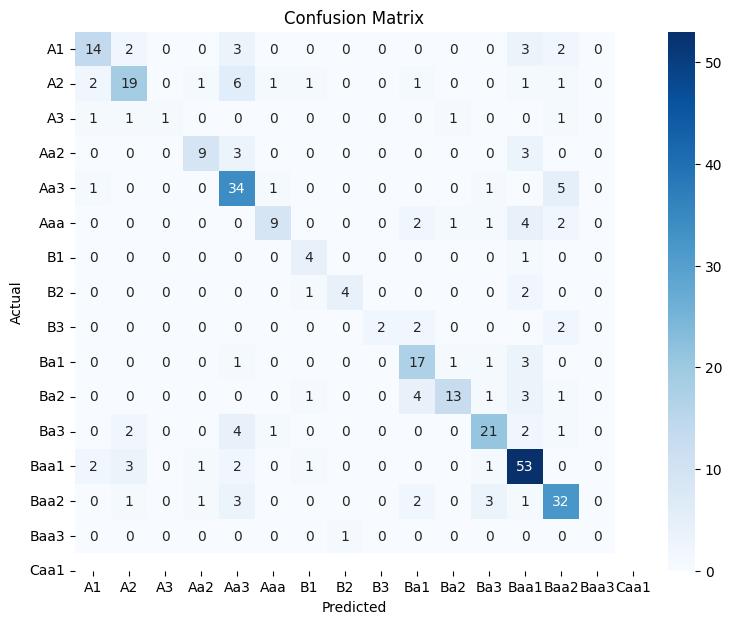

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
class_labels = best_rf_model.named_steps['classifier'].classes_

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
